# New data analysis of the first frames

Eric did experiments on the Sheared Square Ice which resulted in the following plot:
<img src="VertexCount.png" width = "500px">

The proportion of the types 3 and 4A is exaclty what we wanted, and the disapearance of the type 4B is also a good sign.
But we would have expected the system to show charge symmetry. 
The highly charged vertices $|q|=4$ are symmetric, but the $|q| = 3$ vertices, type 2 and 5, are not. 
For some reason, the vertices of type 3 are more common than vertices of type 5. 

This asymmetry could have been attributed to some dynamic effect, but then it would appear after a critical magnetic field. 
Instead the system is asymetric in its initial conditions which points to an error either in the manual placing of the particles, or in the data analysis. 

In the end, we conclude that the asymmetry is caused by a mistreatment of the boundaries. If vertices are not filtered by the location of the vertex, but instead by its coordination, there is a higher probability of positive vertices because colloids are then inside the image. By fixing this we get the two 

### Check existing data

In a previous notebook [CheckinExistingData](CheckingExistingData.ipynb) we obtained the following image:
<img src="FirstFrames2.png" width = "750px">

From these images we can see that there are problems in the tracking. This is evident in both missing particles or spurious features. 
Unfortunately, it appears that these spurious features are not enough to account for the charge imbalance. 
To be sure, in this notebook we redo the particle location for only the first frame of every experiment. We will use the new locations to count vertices and check whether the asymmetry really appears in the initial conditions. 

## Particle location for the first frames

In [1]:
import os
import sys
import glob
sys.path.insert(0, './')

import icenumerics as ice
import correlation_locating as coloc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import trackpy as tp
import pims as pm
from pims import pipeline
from tqdm import tqdm_notebook
import support as sp

%matplotlib inline
idx = pd.IndexSlice

ureg = ice.ureg
@pipeline
def as_gray(frame):
    red = frame[:, :, 0]
    green = frame[:, :, 1]
    blue = frame[:, :, 2]
    return 0.2125 * red + 0.7154 * green + 0.0721 * blue

%load_ext autoreload
%autoreload 2

In [2]:
mpl.rc('text', usetex=True)
mpl.rcParams['figure.dpi'] = 150

In [3]:
## Directory where the data is located
directory = "C:/Users/aortiza/Desktop/ShearedSquare/Theta45"

In [4]:
## Get a list of videos in that folder
theta = 45
filenames = [file for file in glob.glob(
    os.path.join(directory,('*.avi')))]

In this list, some of the videos that are labeled "O1" and "O2" don't have random initial conditions, and we are therefore not interested in them.

In [5]:
filenames = [f for f in filenames if not (f.find("O2")>0) and not (f.find("O1")>0)]

Now we make a function to load the first frame, locate particles, and save the results

In [6]:
# The microscope magnification is:
pxsize = 0.59 # um /pixel
# Then 10um particles should have a radius of:
radius = 5/pxsize
radius

8.474576271186441

#### Improved tracking based on convolution of a simulated particle

In order to improve the tracking, we modify the Crocker-Grier algorithm to find correlation with a sample image. These modifications can be found in the package [correlation_locating](correlation_locating.py).

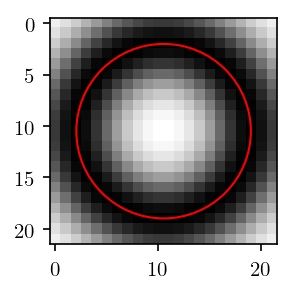

In [7]:
diameter = 2*radius
sim_part = coloc.simulated_particle(diameter,thick_ratio=0.5)
  
coloc.visualize_template(sim_part, diameter=diameter)

C:\Users\aortiza\Anaconda3\lib\site-packages\pims\api.py:191: UserWarning: <class 'pims.pyav_reader.PyAVReaderTimed'> errored: 'NoneType' object has no attribute 'open'
  warn(message)
C:\Users\aortiza\Anaconda3\lib\site-packages\pims\api.py:191: UserWarning: <class 'pims.pyav_reader.PyAVReaderIndexed'> errored: 'NoneType' object has no attribute 'open'
  warn(message)
C:\Users\aortiza\Anaconda3\lib\site-packages\pims\api.py:191: UserWarning: <class 'pims.pyav_reader.PyAVReaderTimed'> errored: 'NoneType' object has no attribute 'open'
  warn(message)
C:\Users\aortiza\Anaconda3\lib\site-packages\pims\api.py:191: UserWarning: <class 'pims.pyav_reader.PyAVReaderIndexed'> errored: 'NoneType' object has no attribute 'open'
  warn(message)


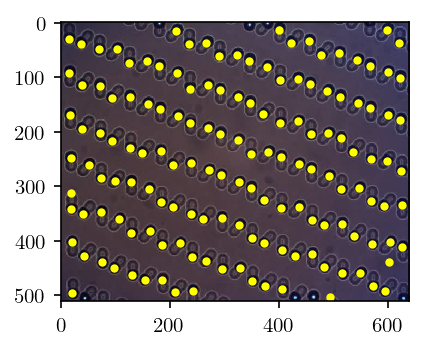

In [8]:
i = 0

@pipeline 
def convolve(image):
    return coloc.template_convolve(image,sim_part)

def locate(filename):
    video = pm.open(filename)
    return tp.locate(convolve(as_gray(video[0])), 2*round(radius)+1, invert=False, characterize=False)

loc = locate(filenames[i])

video = pm.open(filenames[i])
plt.figure(figsize=(3,3))
plt.imshow(video[0])
plt.plot(loc.x,loc.y,".", color="yellow")

In [9]:
locations = pd.concat(
    [locate(filename) for filename in tqdm_notebook(filenames)], keys = range(len(filenames)), names = ["file"])

In [10]:
locations.head()

y           x         mass
file                                      
0    0  12.782989  400.210952  3570.726231
     2  13.244376  598.458021  3259.409548
     3  16.020904  211.404084  4120.839238
     4  29.411606   14.652722  2672.034699
     5  34.325851  455.584655  4015.865016

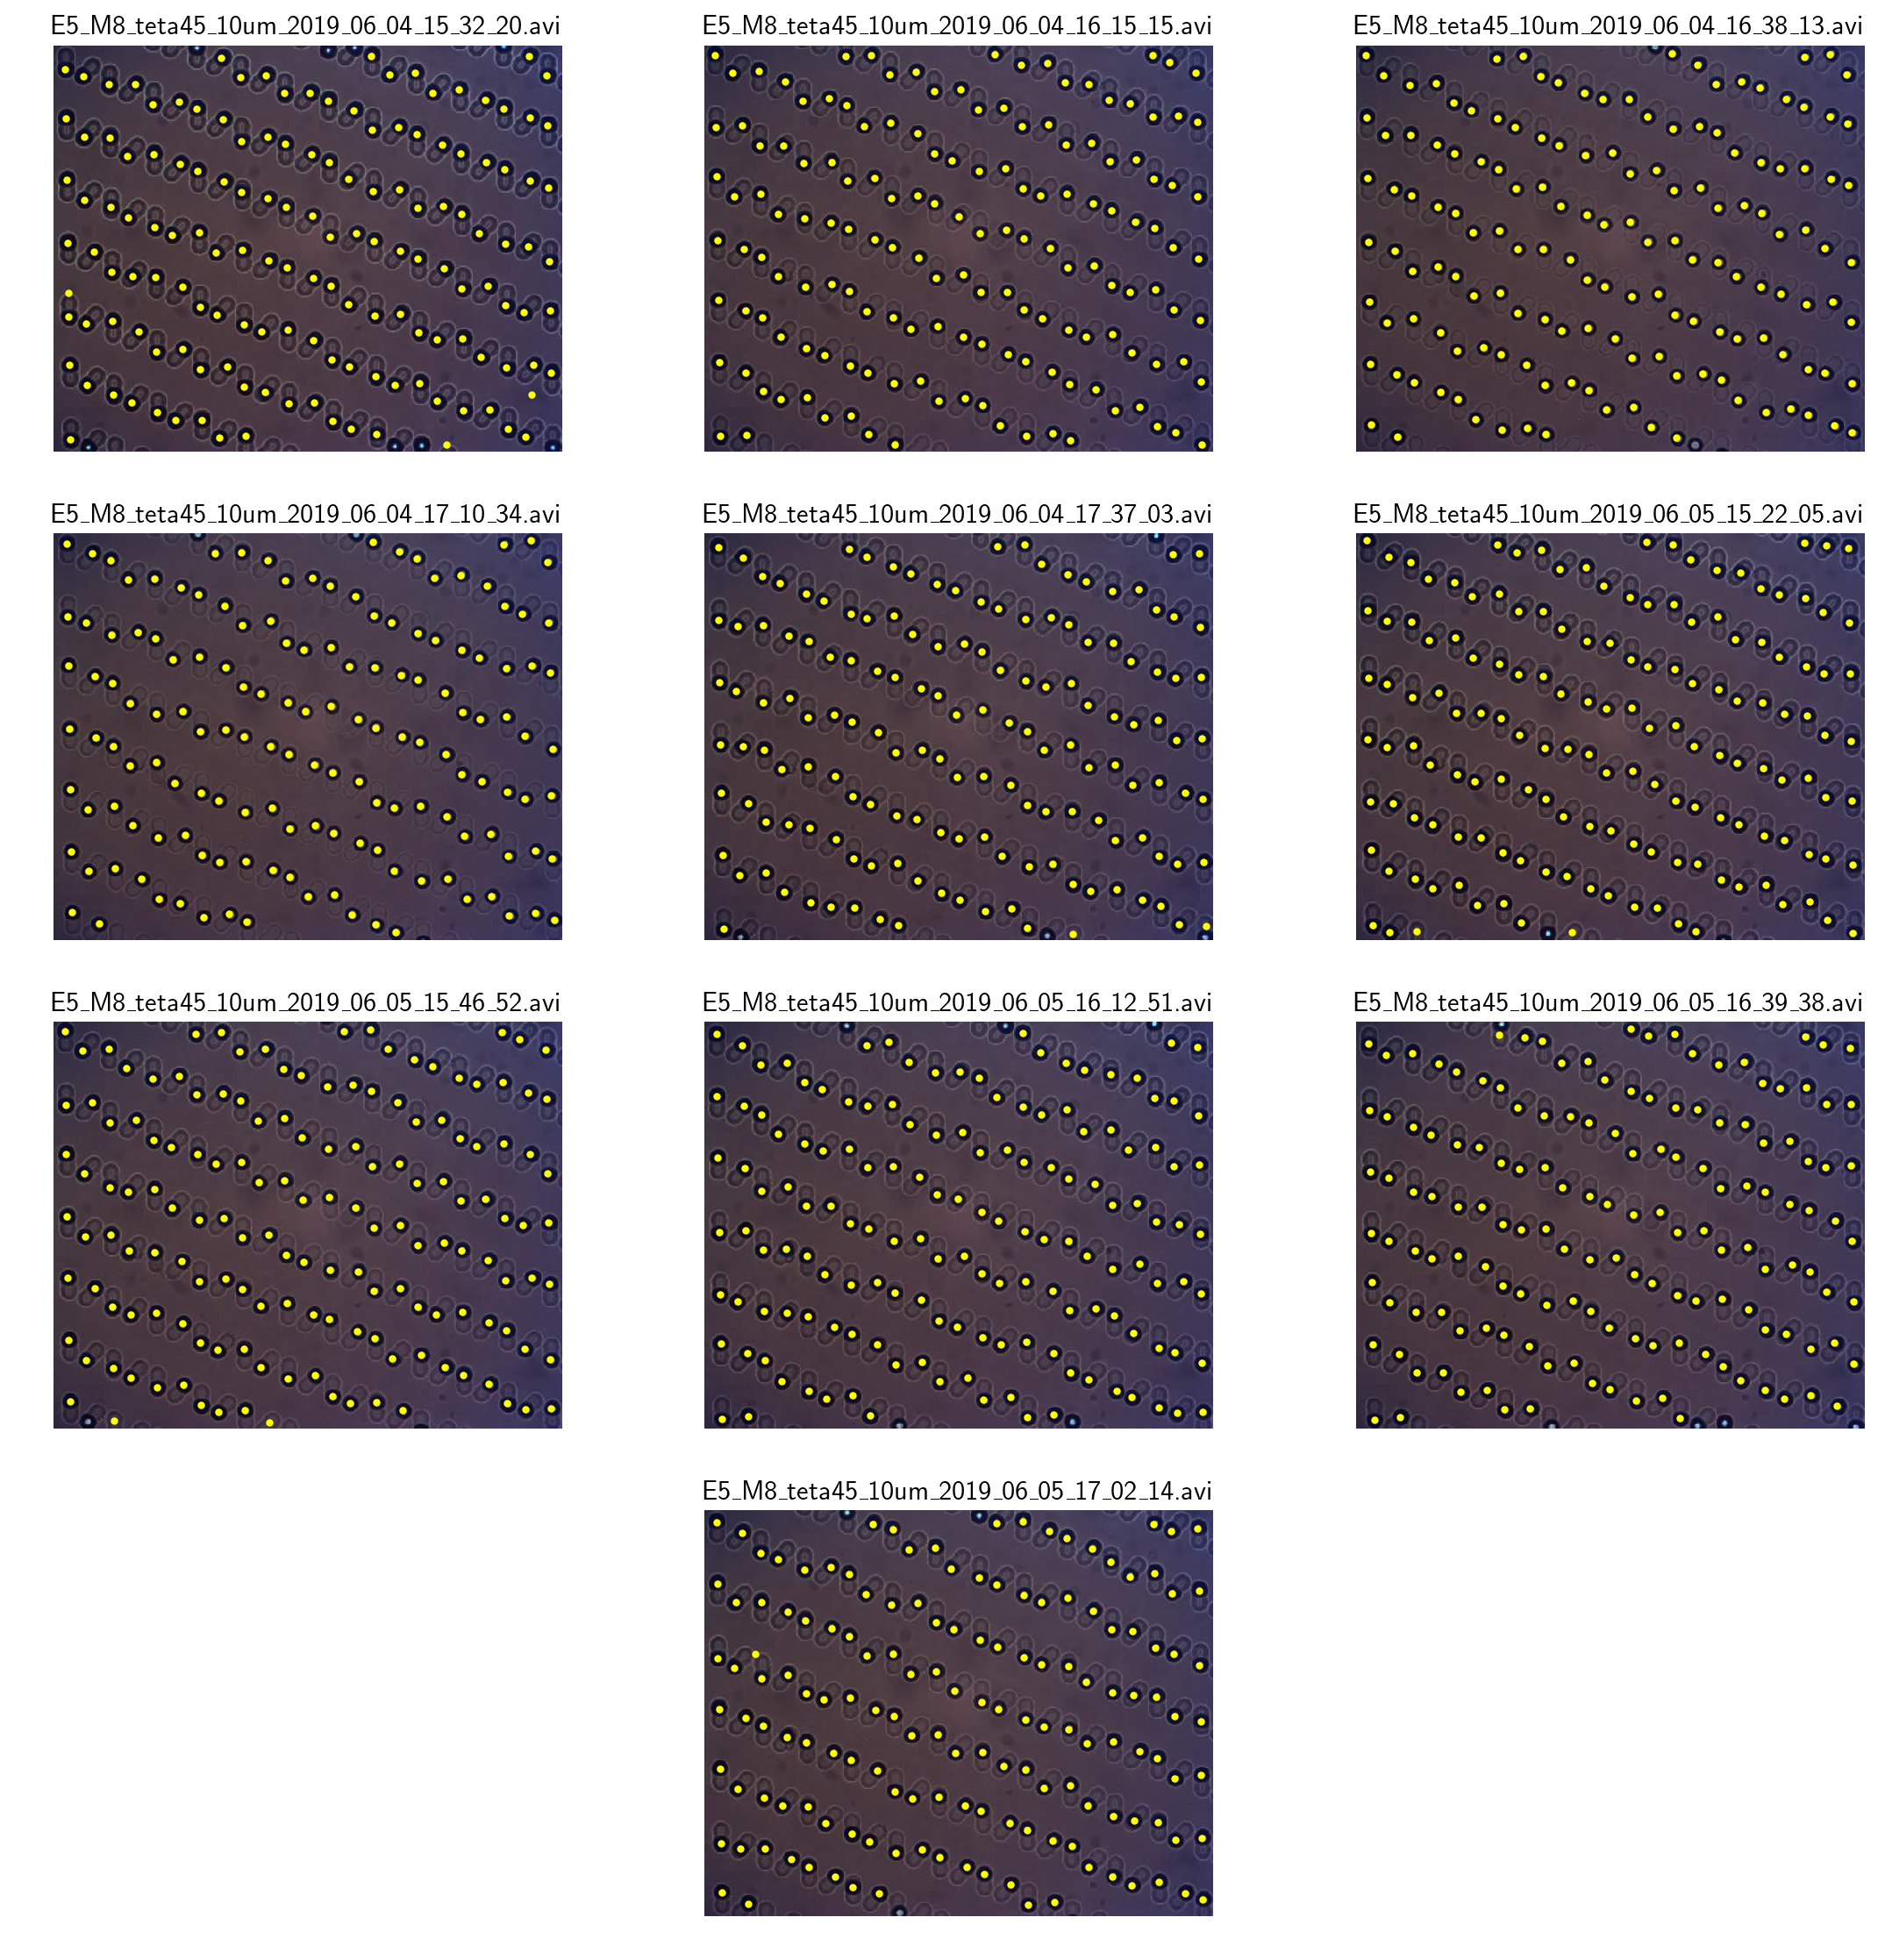

In [11]:
fig, ax = plt.subplots(4,3,figsize=(15,15))

ax.flatten()[-3].remove()
ax.flatten()[-1].remove()
ax = np.delete(ax.flatten(),slice(-3,None,2))

for file_no, name in enumerate(filenames):

    video = pm.open(name)

    disp_name = os.path.split(name)[1]
    disp_name = disp_name.replace("_","\_")    
    
    ax.flatten()[file_no].imshow(video[0])
    ax.flatten()[file_no].plot(locations.loc[idx[file_no,:],"x"],locations.loc[idx[file_no,:],"y"],'.',color="yellow")
    
    ax.flatten()[file_no].set_axis_off()
    ax.flatten()[file_no].set_title("%s"%(disp_name),
                                   fontsize=15)
plt.tight_layout()

From the above figure we can see that this new particle location algorithm (based on the convolution of a simulated particle) is much more robust than the original method. 

## Superimpose a colloidal ice structure

Below we superimpose a colloidal ice structure on the particles. We then classify and count the vertices in this colloidal ice. 

We find that when the boundaries are properly taken into account, the asymmetry between charges disappears. 

In [12]:
from icenumerics.geometry import transformations as tr

The parameters dataset determines the afine transformation that has to be applied to a colloidal ice system to make it match the positions of the colloids. It is determined manualy in the notebook [AlignImagesAndLattices](AlignImagesAndLattices.ipynb)

In [13]:
parameters = pd.read_csv(os.path.join(directory,"parameters.dat"),sep = "\t", index_col = [0])

In [14]:
def strip_name(name,ext): 
    name = os.path.split(name)[-1]
    return name[:name.find(ext)]

In [15]:
parameters.head()

name  \
basename                                                                                   
E5_M8_teta45_10um_2019_06_04_16_15_15  /Users/Eric/Desktop/TFM/Data_shearedsquare/tet...   
E5_M8_teta45_10um_2019_06_04_16_38_13  /Users/Eric/Desktop/TFM/Data_shearedsquare/tet...   
E5_M8_teta45_10um_2019_06_04_17_10_34  /Users/Eric/Desktop/TFM/Data_shearedsquare/tet...   
E5_M8_teta45_10um_2019_06_04_17_37_03  /Users/Eric/Desktop/TFM/Data_shearedsquare/tet...   
E5_M8_teta45_10um_2019_06_05_15_22_05  /Users/Eric/Desktop/TFM/Data_shearedsquare/tet...   

                                       scale  x_offset  y_offset  nx  ny  \
basename                                                                   
E5_M8_teta45_10um_2019_06_04_16_15_15    2.6       619       -12   7   8   
E5_M8_teta45_10um_2019_06_04_16_38_13    2.6       618        -9   7   8   
E5_M8_teta45_10um_2019_06_04_17_10_34    2.6       623       -12   7   8   
E5_M8_teta45_10um_2019_06_04_17_37_03    2.6       623        -8   7   8   
E5_M8_teta45_10um_2019_06_05_15_22_05    2.6       620       -13   7   8   

                                       angle  
basename                                      
E5_M8_teta45_10um_2019_06_04_16_15_15   89.2  
E5_M8_teta45_10um_2019_06_04_16_38_13   89.2  
E5_M8_teta45_10um_2019_06_04_17_10_34   89.2  
E5_M8_teta45_10um_2019_06_04_17_37_03   89.2  
E5_M8_teta45_10um_2019_06_05_15_22_05   89.2

In [16]:
# These are the base objects that are used to construct a colloidal ice structure over the image of the particles.
theta = 45
alpha = (90-theta)/180*np.pi
nx = 7
ny = 11

particle = ice.particle()

trap = ice.trap(trap_sep = 10*ureg.um,
               height = 80*ureg.pN*ureg.nm,
               stiffness = 6e-4*ureg.pN/ureg.nm)

square_spins = ice.spins()
v = ice.vertices()

In [17]:
def particle_locations_to_colloids(locations,i):
    """ converts locations into a colloidal ice """
    fname = filenames[i]
    basename = strip_name(fname,".avi")
    entry = parameters.loc[basename]

    square_spins.create_lattice("square",[nx,ny],lattice_constant = 30*ureg.um)
    sheared_spins = tr.shear(square_spins,alpha)

    sheared_spins = tr.rotate(sheared_spins,(entry[["angle"]].values[0])*ureg.deg)
    sheared_spins = tr.scale(sheared_spins,entry[["scale"]].values[0]*np.array([1,1]))
    sheared_spins = tr.translate(sheared_spins,entry[["x_offset","y_offset"]].values*ureg.um)
    
    col = ice.colloidal_ice(sheared_spins, particle, trap, height_spread = 0, susceptibility_spread = 0.1)
    
    sp.match_colloid_frame(col,locations)

    return col

In [18]:
def filter_vertices(vert_frame,box):
    """ Filters out vertices located outside of a box"""
    theta = box.angle/180*np.pi
    
    X = vert_frame[:].LocationX
    Y = vert_frame[:].LocationY

    Xt = X*np.cos(theta)-Y*np.sin(theta)
    Yt = X*np.sin(theta)+Y*np.cos(theta)
    
    x0,y0 = box.xy
    
    xf = x0 + box.get_width()
    yf = y0 + box.get_height()

    crit = (Xt>x0) & (Xt<xf) & (Yt>y0) & (Yt<yf)
    return vert_frame[crit]

In [19]:
left = 30
right = 30
bottom = 60
top = 60

def particle_locations_to_vertices(locations,i):
    """ converts particle locations into an array of vertices """
    col = particle_locations_to_colloids(locations,i)

    v = ice.vertices()
    v.colloids_to_vertices(col)
    
    vertices = sp.vertices_array_to_pd(v)
    
    fname = filenames[i]
    basename = strip_name(fname,".avi")
    entry = parameters.loc[basename]

    box = mpl.patches.Rectangle(
        (left+(entry.x_offset-620),bottom+(entry.y_offset+10)),
        (video[0].shape[1]-left-right),(video[0].shape[0]-bottom-top),
        angle = entry.angle-90, alpha = 0.2)

    vert_frame = filter_vertices(vertices, box)

    return vert_frame

In [20]:
locations.head()

y           x         mass
file                                      
0    0  12.782989  400.210952  3570.726231
     2  13.244376  598.458021  3259.409548
     3  16.020904  211.404084  4120.839238
     4  29.411606   14.652722  2672.034699
     5  34.325851  455.584655  4015.865016

In [21]:
# Applies the function particle_locations_to_vertices iteratively.
vertices = pd.concat(
    [particle_locations_to_vertices(loc.reset_index(level=0,drop=True),i) for i,loc in locations.groupby("file")],
    keys=locations.index.get_level_values("file").unique(), names = ["file"])

C:\Users\aortiza\Anaconda3\lib\site-packages\pint\quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


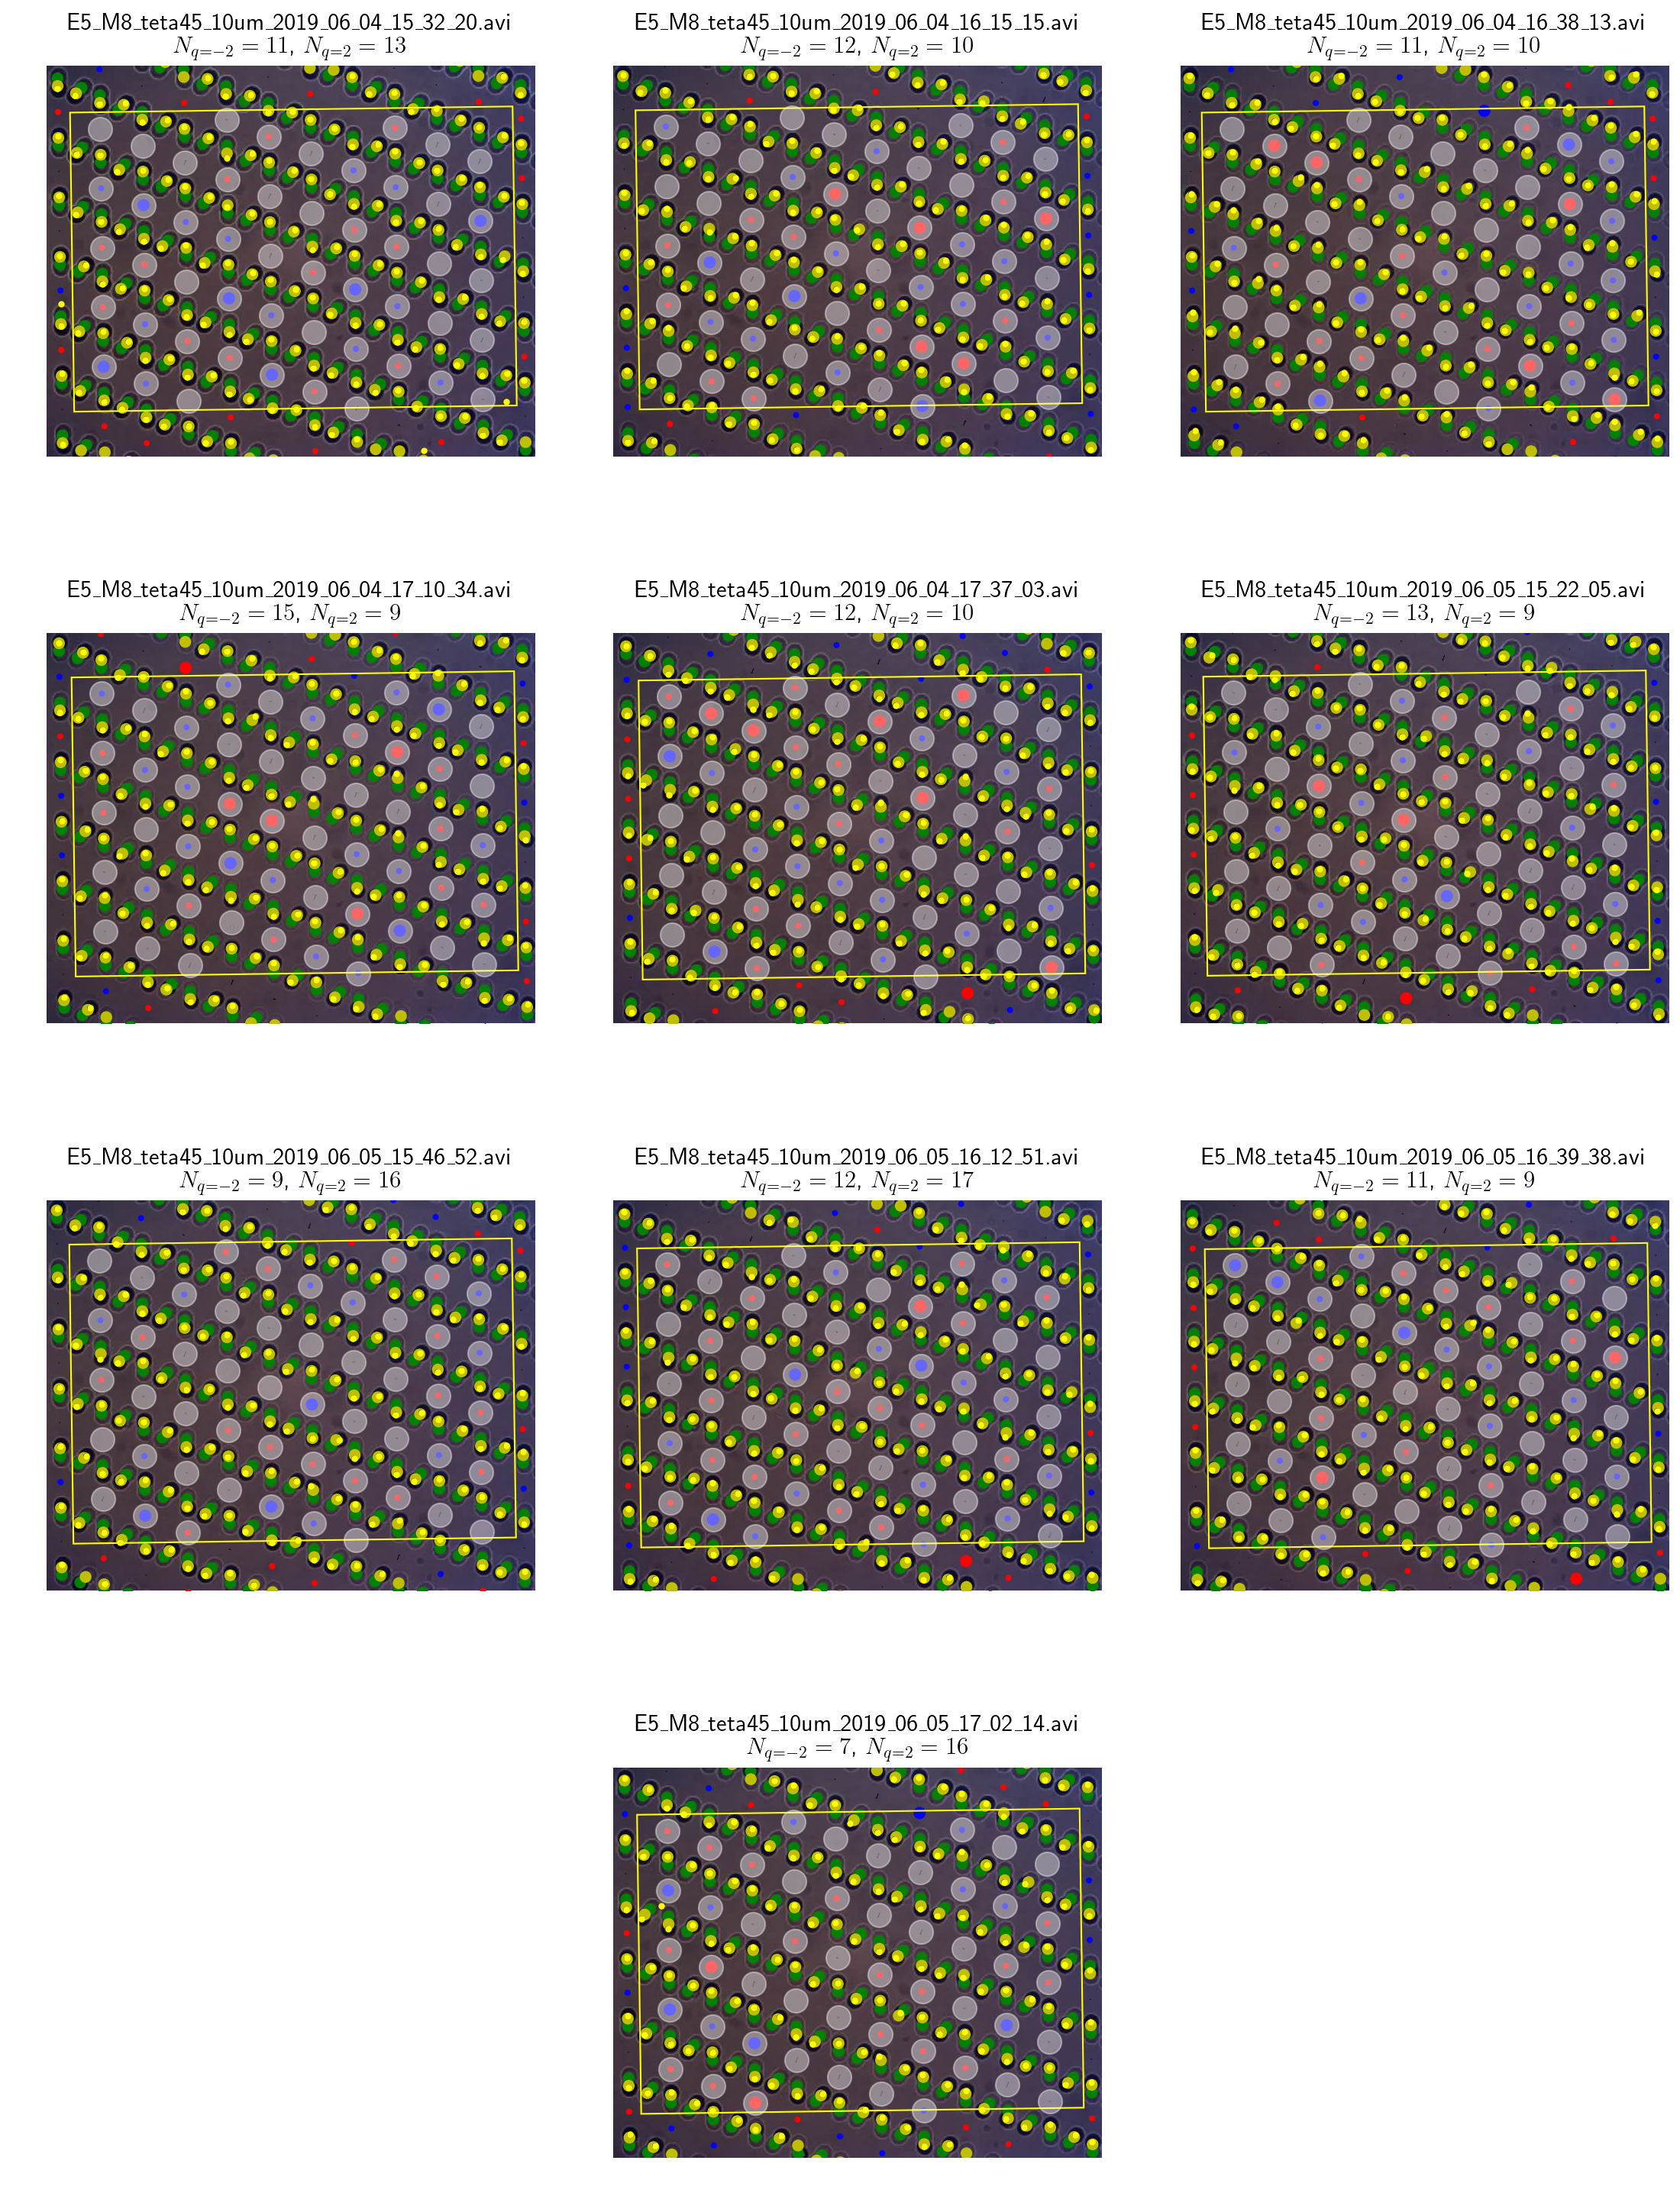

In [22]:
# Plot the first frame of all the videos. 

fig, ax = plt.subplots(4,3,figsize=(15,20))

ax.flatten()[-3].remove()
ax.flatten()[-1].remove()
ax = np.delete(ax.flatten(),slice(-3,None,2))


for file_no, name in enumerate(filenames[0:]):

    fname = filenames[file_no]
    basename = strip_name(fname,".avi")
    entry = parameters.loc[basename]

    video = pm.open(fname)
    box = mpl.patches.Rectangle(
        (left+(entry.x_offset-620),bottom+(entry.y_offset+10)),
        (video[0].shape[1]-left-right),(video[0].shape[0]-bottom-top),
        angle = entry.angle-90, alpha = 1, fill=False, edgecolor = "yellow")
    
    vert_frame = vertices.loc[idx[file_no,:],:]
    T5 = vert_frame[(vert_frame.Coordination==4) & (vert_frame.Charge==2)]
    T3 = vert_frame[(vert_frame.Coordination==4) & (vert_frame.Charge==-2)]
    
    ax.flatten()[file_no].imshow(video[0])
    
    col = particle_locations_to_colloids(locations.loc[idx[file_no,:],:].reset_index(level=0,drop=True),file_no)
    
    ax.flatten()[file_no].plot(vert_frame.loc[:,"LocationX"],vert_frame.loc[:,"LocationY"],
                           'o',color="white", markersize = 15, alpha = 0.4)

    v = ice.vertices()
    v.colloids_to_vertices(col)
    sp.vertices_pd_to_array(v,vert_frame.reset_index(level=0,drop=True))
    
    col.display(ax.flatten()[file_no])
    ax.flatten()[file_no].plot(locations.loc[idx[file_no,:],"x"],locations.loc[idx[file_no,:],"y"],'.',color="yellow")
    
    v.display(ax.flatten()[file_no])
    ax.flatten()[file_no].set_xlim(0,video[0].shape[1])
    ax.flatten()[file_no].set_ylim(video[0].shape[0],0)
    
    disp_name = os.path.split(name)[1]
    disp_name = disp_name.replace("_","\_")
    
    ax.flatten()[file_no].set_axis_off()
    ax.flatten()[file_no].set_title("%s \n$N_{q=-2} = %u$, $N_{q=2} = %u$"%(disp_name,len(T3),len(T5)),
                                   fontsize=15)
    
    ax.flatten()[file_no].add_patch(box)
    
plt.tight_layout()

In [23]:
vertices.groupby("Charge").count()

Coordination  DipoleX  DipoleY  LocationX  LocationY
Charge                                                      
-4                31       31       31         31         31
-2               113      113      113        113        113
 0               210      210      210        210        210
 2               119      119      119        119        119
 4                27       27       27         27         27

From this vertex count we see htat the difference between charges is not significant. This means that the asymmetry was caused by a wrong accounting for the boundaries.

In [24]:
vertex_per_frame = vertices.groupby("file").count().mean().filter(["Coordination"])
(vertices.groupby(["file","Charge"]).count()/vertex_per_frame).groupby("Charge").mean().Coordination

Charge
-4    0.0620
-2    0.2260
 0    0.4200
 2    0.2380
 4    0.0675
Name: Coordination, dtype: float64

In [25]:
multiplicity = pd.DataFrame(data = [1, 4, 6, 4, 1], columns = ["multiplicity"])
multiplicity["Charge"] = [-4,-2,0,2,4]
multiplicity["probability"] = multiplicity.multiplicity/sum(multiplicity.multiplicity)
multiplicity

multiplicity  Charge  probability
0             1      -4       0.0625
1             4      -2       0.2500
2             6       0       0.3750
3             4       2       0.2500
4             1       4       0.0625

There is a slight over representation of the q=0, hopefully this is not very problematic.